In [1]:
#!pip install --upgrade pip
#!pip install torch transformers accelerate pymc arviz regex
#!pip install --upgrade transformers

In [2]:
# Example from https://huggingface.co/facebook/webssl-dino300m-full2b-224
from transformers import AutoImageProcessor, Dinov2Model
import torch
from PIL import Image

processor = AutoImageProcessor.from_pretrained('facebook/webssl-dino300m-full2b-224')
model = Dinov2Model.from_pretrained('facebook/webssl-dino300m-full2b-224')

# Process an image
image = Image.open('/content/me_dark.PNG')
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

cls_features = outputs.last_hidden_state[:, 0]  # CLS token features
patch_features = outputs.last_hidden_state[:, 1:] # patch-wise token features


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

In [3]:
# Some more interesting examples :)

Successfully loaded processor and model for: facebook/webssl-dino300m-full2b-224
Feature dimension: 1024
Number of patches: 256
Patch grid size: 16x16

Generating PCA visualization...
PCA visualization generated.

Generating CLS similarity visualization...
CLS similarity visualization generated.


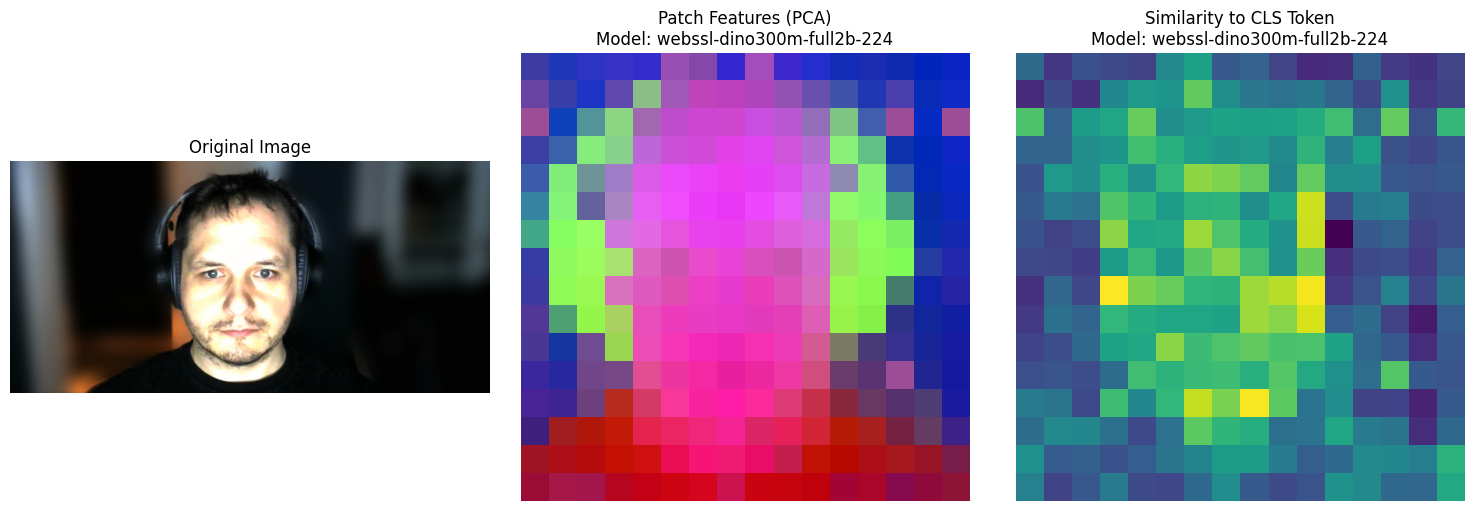

In [4]:
# Ensure libraries are installed
# !pip install transformers torch Pillow matplotlib scikit-learn

# Get features from image and visualize them

from transformers import AutoImageProcessor, Dinov2Model
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import math

# --- Configuration ---
# Here you can also use dinov2 if you want to compare
model_name = 'facebook/webssl-dino300m-full2b-224'

# --- Model Loading ---
try:
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = Dinov2Model.from_pretrained(model_name)
    print(f"Successfully loaded processor and model for: {model_name}")
except Exception as e:
    print(f"Error loading model '{model_name}': {e}")
    print("Please ensure the model name is correct and accessible.")
    raise SystemExit("Model loading failed.")

# --- Image Loading ---
try:
    # Replace with the actual path to your image file if needed
    image_path = '/content/me_dark.PNG' # Using the uploaded filename from test examples
    image = Image.open(image_path).convert('RGB') # Ensure image is RGB
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    print("Please provide a valid path to an image file.")
    print("Using a dummy black image instead.")
    image = Image.new('RGB', (224, 224), color = 'black')

# --- Feature Extraction ---
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

cls_features = outputs.last_hidden_state[:, 0]   # CLS token features (batch_size, feature_dim)
patch_features = outputs.last_hidden_state[:, 1:] # patch-wise token features (batch_size, num_patches, feature_dim)

# --- Visualization ---

# 1. Get dimensions
batch_size, num_patches, feature_dim = patch_features.shape
print(f"Feature dimension: {feature_dim}")
print(f"Number of patches: {num_patches}")

# 2. Calculate grid size
patches_per_side = int(math.sqrt(num_patches))
if patches_per_side * patches_per_side != num_patches:
    print(f"Warning: Number of patches ({num_patches}) is not a perfect square. Visualization might be inaccurate.")
else:
    print(f"Patch grid size: {patches_per_side}x{patches_per_side}")

# Make sure we only work with the first image if batch_size > 1
patch_features_np = patch_features[0].cpu().numpy() # Shape: (num_patches, feature_dim)
cls_features_np = cls_features[0].cpu().numpy()     # Shape: (feature_dim,)

# --- Visualization Method 1: PCA on Patch Features ---
print("\nGenerating PCA visualization...")
try:
    pca = PCA(n_components=3)
    pca_features = pca.fit_transform(patch_features_np)
    scaler = MinMaxScaler()
    pca_features_normalized = scaler.fit_transform(pca_features)
    pca_image = pca_features_normalized.reshape(patches_per_side, patches_per_side, 3)
    pca_visualization_possible = True
    print("PCA visualization generated.")
except Exception as e:
    print(f"Error during PCA visualization: {e}")
    pca_visualization_possible = False

# --- Visualization Method 2: Cosine Similarity with CLS Token ---
print("\nGenerating CLS similarity visualization...")
try:
    # Normalize CLS feature vector
    cls_norm_val = np.linalg.norm(cls_features_np)
    cls_norm = cls_features_np / (cls_norm_val + 1e-9) # Add epsilon for safety

    # Normalize patch feature vectors (using simpler/safer method)
    epsilon = 1e-9
    patch_norms_values = np.linalg.norm(patch_features_np, axis=1, keepdims=True) # Shape (num_patches, 1)
    patch_norms = patch_features_np / (patch_norms_values + epsilon) # Shape (num_patches, feature_dim)

    # Calculate dot product (cosine similarity for normalized vectors)
    similarities = np.dot(patch_norms, cls_norm) # Shape (num_patches, 1024) dot (1024,) -> (num_patches,)

    # Normalize similarities to [0, 1] for visualization
    sim_min, sim_max = similarities.min(), similarities.max()
    if sim_max > sim_min:
         similarities_normalized = (similarities - sim_min) / (sim_max - sim_min)
    else:
         similarities_normalized = np.zeros_like(similarities)

    # Reshape the similarities into an image grid
    similarity_map = similarities_normalized.reshape(patches_per_side, patches_per_side)
    similarity_visualization_possible = True
    print("CLS similarity visualization generated.")
except Exception as e:
    print(f"Error during CLS similarity visualization: {e}")
    similarity_visualization_possible = False

# --- Display Results ---
num_plots = 1 + pca_visualization_possible + similarity_visualization_possible
plt.figure(figsize=(5 * num_plots, 5))
plot_index = 1

# Plot Original Image
plt.subplot(1, num_plots, plot_index)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plot_index += 1

# Plot PCA Visualization
if pca_visualization_possible:
    plt.subplot(1, num_plots, plot_index)
    plt.imshow(pca_image, interpolation='nearest')
    plt.title(f'Patch Features (PCA)\nModel: {model_name.split("/")[-1]}')
    plt.axis('off')
    plot_index += 1

# Plot Similarity Map
if similarity_visualization_possible:
    plt.subplot(1, num_plots, plot_index)
    plt.imshow(similarity_map, cmap='viridis', interpolation='nearest')
    plt.title(f'Similarity to CLS Token\nModel: {model_name.split("/")[-1]}')
    plt.axis('off')
    plot_index += 1

plt.tight_layout()
plt.show()

Successfully loaded processor and model for: facebook/webssl-dino300m-full2b-224
Extracted hidden states from 24 transformer layers (plus initial embeddings).
Patch grid: 16x16
PCA fitted on features from the final layer.
Scaler fitted on PCA features from the final layer.
Generating frames for each layer...


Processing Layers:   0%|          | 0/24 [00:00<?, ?it/s]


Saving MP4 video to dino_layer_pca_video_webssl-dino300m-full2b-224.mp4...
Saving GIF to dino_layer_pca_animation_webssl-dino300m-full2b-224.gif...
Done.


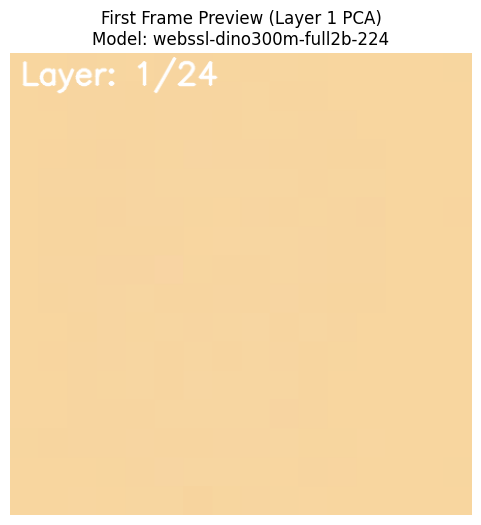


Video saved as 'dino_layer_pca_video_webssl-dino300m-full2b-224.mp4' and 'dino_layer_pca_animation_webssl-dino300m-full2b-224.gif' in your Colab environment.
You can download them from the file browser on the left.


In [15]:
# Ensure libraries are installed
#!pip install imageio imageio[ffmpeg] opencv-python scikit-learn transformers torch Pillow matplotlib

# Image example with viusalizatiopn of the different layers of the model

from transformers import AutoImageProcessor, Dinov2Model
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import math
import imageio # For creating the video/gif
import cv2 # For resizing and adding text
from tqdm.notebook import tqdm # For progress bar

# --- Configuration ---
# you can also try 'facebook/dinov2-base' if you want to compare
model_name = 'facebook/webssl-dino300m-full2b-224'

# --- Model Loading ---
try:
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = Dinov2Model.from_pretrained(model_name)
    print(f"Successfully loaded processor and model for: {model_name}")
except Exception as e:
    print(f"Error loading model '{model_name}': {e}")
    print("Please ensure the model name is correct and accessible.")
    # Exit or raise error if model loading fails
    raise SystemExit("Model loading failed.")


# --- Image Loading ---
try:
    # Replace with the actual path to your image file
    image_path = '/content/me_dark.PNG'
    image = Image.open(image_path).convert('RGB')
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    print("Please provide a valid path to an image file.")
    print("Using a dummy black image instead.")
    image = Image.new('RGB', (224, 224), color = 'black')

# --- Feature Extraction (with all hidden states) ---
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    # Request hidden states from all layers
    outputs = model(**inputs, output_hidden_states=True)

# `outputs.hidden_states` is a tuple: (initial_embeddings, layer1_out, layer2_out, ...)
# Check if hidden_states were actually returned
if outputs.hidden_states is None:
     print(f"Error: Model '{model_name}' did not return hidden states. Cannot generate layer video.")
     print("Ensure the model architecture supports 'output_hidden_states=True'.")
     raise SystemExit("Hidden states not available.")

all_hidden_states = outputs.hidden_states
num_layers = len(all_hidden_states) - 1 # Exclude initial embeddings count for layer numbering
print(f"Extracted hidden states from {num_layers} transformer layers (plus initial embeddings).")

# Use the final layer's patch features to fit PCA and Scaler
final_patch_features = all_hidden_states[-1][:, 1:] # (batch_size, num_patches, feature_dim)
batch_size, num_patches, feature_dim = final_patch_features.shape

# Check if we got any patches
if num_patches == 0:
    print("Error: Model output contains 0 patches.")
    raise SystemExit("No patch features found.")

patches_per_side = int(math.sqrt(num_patches))
if patches_per_side * patches_per_side != num_patches:
     print(f"Warning: Number of patches ({num_patches}) is not a perfect square. Assuming {patches_per_side}x{patches_per_side} grid.")
else:
     print(f"Patch grid: {patches_per_side}x{patches_per_side}")

# Prepare final layer features for PCA fitting
final_patch_features_np = final_patch_features[0].cpu().numpy() # Use first image in batch

# --- Fit PCA and Scaler ---
try:
    pca = PCA(n_components=3)
    pca.fit(final_patch_features_np)
    print("PCA fitted on features from the final layer.")

    final_pca_features = pca.transform(final_patch_features_np)
    scaler = MinMaxScaler()
    scaler.fit(final_pca_features)
    print("Scaler fitted on PCA features from the final layer.")
    pca_scaler_fitted = True
except Exception as e:
    print(f"Error fitting PCA/Scaler: {e}")
    pca_scaler_fitted = False


# --- Generate Video Frames ---
video_frames = []
output_frame_size = (448, 448) # Increase size for better viewing

if pca_scaler_fitted:
    print("Generating frames for each layer...")
    # Loop through hidden states (skip initial embeddings for layer count)
    for i, hidden_state in enumerate(tqdm(all_hidden_states[1:], desc="Processing Layers")):
        layer_num = i + 1
        current_patch_features = hidden_state[0, 1:, :].cpu().numpy() # (num_patches, feature_dim)

        # Apply the *same* PCA transformation
        try:
            pca_features = pca.transform(current_patch_features)
        except Exception as e:
             print(f"Error applying PCA transform for layer {layer_num}: {e}. Skipping frame.")
             continue

        # Apply the *same* Scaler transformation
        # Clip values to [0, 1] as features from earlier layers might be outside the final layer's range
        try:
            pca_features_normalized = np.clip(scaler.transform(pca_features), 0, 1)
        except Exception as e:
             print(f"Error applying Scaler transform for layer {layer_num}: {e}. Skipping frame.")
             continue

        # Reshape into image grid
        try:
            # Use floor/ceil or other logic if not perfect square? For now, rely on calculated patches_per_side
            pca_image = pca_features_normalized.reshape(patches_per_side, patches_per_side, 3)
        except ValueError as e:
            print(f"Error reshaping PCA features for layer {layer_num} ({patches_per_side}x{patches_per_side}): {e}. Skipping frame.")
            continue

        # Convert to uint8 for video processing
        frame_uint8 = (pca_image * 255).astype(np.uint8)

        # Resize the small patch grid to the desired output frame size
        resized_frame = cv2.resize(frame_uint8, output_frame_size, interpolation=cv2.INTER_NEAREST)

        # Add layer number text
        text = f"Layer: {layer_num}/{num_layers}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        org = (10, 30) # Position (bottom-left corner)
        fontScale = 1
        color = (255, 255, 255) # White
        thickness = 2
        cv2.putText(resized_frame, text, org, font, fontScale, color, thickness, cv2.LINE_AA)

        video_frames.append(resized_frame)
else:
    print("Skipping frame generation because PCA/Scaler fitting failed.")

# --- Save the Video ---
if video_frames:
    output_filename_mp4 = f'dino_layer_pca_video_{model_name.split("/")[-1]}.mp4'
    output_filename_gif = f'dino_layer_pca_animation_{model_name.split("/")[-1]}.gif'
    fps = 2 # Frames per second (adjust as needed)

    print(f"\nSaving MP4 video to {output_filename_mp4}...")
    imageio.mimsave(output_filename_mp4, video_frames, fps=fps)
    print(f"Saving GIF to {output_filename_gif}...")
    imageio.mimsave(output_filename_gif, video_frames, fps=fps)
    print("Done.")

    # Display the first frame as a preview (optional)
    plt.figure(figsize=(6, 6))
    plt.imshow(video_frames[0])
    plt.title(f"First Frame Preview (Layer 1 PCA)\nModel: {model_name.split('/')[-1]}")
    plt.axis('off')
    plt.show()

    print(f"\nVideo saved as '{output_filename_mp4}' and '{output_filename_gif}' in your Colab environment.")
    print("You can download them from the file browser on the left.")
elif not pca_scaler_fitted:
     print("Video not created because PCA/Scaler fitting failed.")
else:
    print("No frames were generated, cannot save video.")

In [6]:
# Ensure libraries are installed
# !pip install imageio imageio[ffmpeg] opencv-python scikit-learn transformers torch Pillow matplotlib tqdm

# video example, creates feature visualization

import torch
from transformers import AutoImageProcessor, Dinov2Model
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import math
import imageio # For reading/writing video
import cv2 # For resizing and adding text
from tqdm.notebook import tqdm # For progress bar
import os # For path manipulation
# import matplotlib.pyplot as plt # Uncomment if you want the final plot display

# --- Configuration ---
#model_name = 'facebook/dinov2-base' # Using base for potentially faster processing on video
model_name = 'facebook/webssl-dino300m-full2b-224' # Or keep your original model

# --- VIDEO INPUT ---
# <<<--- CHANGE THIS PATH --->>>
video_path = '/content/ShortVD_np.mp4' # Replace with the actual path to your video file
# <<<-------------------->>>

output_dir = '/content/' # Directory to save the output video
output_frame_size = (448, 448) # Size of each frame in the output video (width, height)
max_frames_to_process = 50 # Set to an integer to process only the first N frames, or None for all
output_fps = 15 # Frames per second for the output video (adjust as needed)
save_gif = False # Set to True if you want the GIF output as well (can be slow/large)

# --- GPU Setup (Optional but Recommended for Speed) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Model Loading ---
processor = None
model = None
try:
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = Dinov2Model.from_pretrained(model_name).to(device) # Move model to GPU if available
    model.eval() # Set model to evaluation mode
    print(f"Successfully loaded processor and model for: {model_name}")
except Exception as e:
    print(f"Error loading model '{model_name}': {e}")
    print("Please ensure the model name is correct and accessible.")
    raise SystemExit("Model loading failed.")

# --- Video Loading and PCA/Scaler Fitting ---
pca = None
scaler = None
patches_per_side = None
pca_scaler_fitted = False
num_patches = -1 # Initialize
reader_for_fit = None # Separate reader instance for fitting

try:
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found at {video_path}")

    print(f"Reading video file for first frame analysis: {video_path}")
    reader_for_fit = imageio.get_reader(video_path, 'ffmpeg')
    # Get video metadata (optional but useful)
    meta = reader_for_fit.get_meta_data()
    input_fps = meta.get('fps', output_fps) # Use input fps if available, else default
    duration = meta.get('duration', 'N/A')
    try:
        nframes_meta = reader_for_fit.count_frames()
    except Exception:
        nframes_meta = 'Unknown'
    print(f"Input video (metadata): FPS={input_fps}, Duration={duration}s, Frames={nframes_meta}")

    # --- Fit PCA and Scaler on the First Frame ---
    print("Processing first frame to fit PCA and Scaler...")
    first_frame_np = reader_for_fit.get_data(0) # Read the first frame (index 0)
    first_frame_pil = Image.fromarray(first_frame_np).convert('RGB')

    # Extract features for the first frame
    inputs = processor(images=first_frame_pil, return_tensors="pt").to(device)
    with torch.no_grad():
        # We only need the last hidden state to fit PCA/Scaler
        outputs = model(**inputs) # No need for output_hidden_states=True here

    # Use the final layer's patch features to fit PCA and Scaler
    # last_hidden_state shape: (batch_size, sequence_length, feature_dim)
    # sequence_length includes [CLS] token + patches
    final_patch_features = outputs.last_hidden_state[:, 1:] # Exclude [CLS] token
    batch_size, num_patches, feature_dim = final_patch_features.shape

    if num_patches == 0:
        print("Error: Model output contains 0 patches for the first frame.")
        raise SystemExit("No patch features found.")

    patches_per_side = int(math.sqrt(num_patches))
    if patches_per_side * patches_per_side != num_patches:
        print(f"Warning: Number of patches ({num_patches}) is not a perfect square. Assuming {patches_per_side}x{patches_per_side} grid.")
    else:
        print(f"Patch grid determined from first frame: {patches_per_side}x{patches_per_side}")

    # Prepare final layer features for PCA fitting
    final_patch_features_np = final_patch_features[0].cpu().numpy() # Use first image in batch, move to CPU

    # Fit PCA and Scaler
    pca = PCA(n_components=3)
    pca.fit(final_patch_features_np)
    print("PCA fitted on features from the final layer of the first frame.")

    final_pca_features = pca.transform(final_patch_features_np)
    scaler = MinMaxScaler()
    scaler.fit(final_pca_features)
    print("Scaler fitted on PCA features from the final layer of the first frame.")
    pca_scaler_fitted = True

except FileNotFoundError as fnf_err:
    print(f"Error: {fnf_err}")
    print("Please provide a valid path to a video file in the 'video_path' variable.")
    raise SystemExit("Video file not found.")
except Exception as e:
    print(f"Error during initial video processing or PCA fitting: {e}")
    pca_scaler_fitted = False
finally:
    # Close the reader used for fitting
    if reader_for_fit is not None:
        try:
            reader_for_fit.close()
            print("Closed reader used for PCA fitting.")
        except Exception as close_err:
             print(f"Error closing reader used for fitting: {close_err}")


# --- Process Video Frames ---
output_video_frames = []
reader_for_proc = None # Separate reader instance for processing
progress_bar = None

if pca_scaler_fitted:
    print("\nProcessing video frames...")
    try:
        reader_for_proc = imageio.get_reader(video_path, 'ffmpeg') # Re-open reader for processing

        # --- Determine total frames for progress bar, if possible ---
        try:
            total_frames_for_display = reader_for_proc.count_frames()
        except Exception:
            total_frames_for_display = None

        # Set the tqdm total based on max_frames_to_process or detected count
        tqdm_total = None
        if max_frames_to_process is not None:
            tqdm_total = max_frames_to_process
            if total_frames_for_display is not None:
                tqdm_total = min(total_frames_for_display, max_frames_to_process)
        elif total_frames_for_display is not None:
            tqdm_total = total_frames_for_display

        print(f"Will process up to {max_frames_to_process if max_frames_to_process is not None else 'all available'} frames.")
        if tqdm_total is not None:
            print(f"Progress bar total set to: {tqdm_total}")
        else:
            print("Progress bar total unknown (will update as frames are processed).")

        # --- Iterate through frames using enumerate ---
        progress_bar = tqdm(enumerate(reader_for_proc), total=tqdm_total, desc="Processing Frames")

        for frame_idx, frame_np in progress_bar:
            # --- FRAME LIMIT CHECK ---
            if max_frames_to_process is not None and frame_idx >= max_frames_to_process:
                print(f"\nReached specified max_frames_to_process limit ({max_frames_to_process}). Stopping.")
                break # Exit the loop

            # --- Frame Processing Logic ---
            try:
                current_frame_pil = Image.fromarray(frame_np).convert('RGB')

                # Process the current frame through the model
                inputs = processor(images=current_frame_pil, return_tensors="pt").to(device)
                with torch.no_grad():
                    outputs = model(**inputs)

                # Extract final layer patch features
                current_patch_features_all = outputs.last_hidden_state[:, 1:] # (batch, num_patches, dim)

                # Check if number of patches matches the one used for fitting
                if current_patch_features_all.shape[1] != num_patches:
                    print(f"Warning: Frame {frame_idx} has {current_patch_features_all.shape[1]} patches, expected {num_patches}. Trying to reshape input or skipping frame.")
                    # Potential cause: variable video resolution? For simplicity, skip.
                    # Advanced: could try resizing frame_np to a fixed size before Image.fromarray
                    continue

                current_patch_features = current_patch_features_all[0].cpu().numpy() # (num_patches, dim)

                # Apply the *fitted* PCA transformation
                pca_features = pca.transform(current_patch_features)

                # Apply the *fitted* Scaler transformation
                pca_features_normalized = np.clip(scaler.transform(pca_features), 0, 1)

                # Reshape into image grid
                pca_image = pca_features_normalized.reshape(patches_per_side, patches_per_side, 3)

                # Convert to uint8 for video processing
                frame_uint8 = (pca_image * 255).astype(np.uint8)

                # Resize the small patch grid to the desired output frame size
                resized_frame = cv2.resize(frame_uint8, output_frame_size, interpolation=cv2.INTER_NEAREST)

                # Add frame number text (optional)
                text = f"Frame: {frame_idx}"
                font = cv2.FONT_HERSHEY_SIMPLEX
                org = (10, 30) # Position (bottom-left corner)
                fontScale = 1
                color = (255, 255, 255) # White
                thickness = 2
                cv2.putText(resized_frame, text, org, font, fontScale, color, thickness, cv2.LINE_AA)

                output_video_frames.append(resized_frame)

            except Exception as frame_proc_err:
                 # Catch errors during processing of a single frame
                 print(f"\nError processing frame {frame_idx}: {frame_proc_err}. Skipping frame.")
                 continue # Skip to the next frame

    except Exception as e:
        print(f"\nError during video reading or main frame processing loop: {e}")
    finally:
        # --- Ensure reader and progress bar are closed ---
        if progress_bar is not None:
             progress_bar.close()
        if reader_for_proc is not None:
            try:
                reader_for_proc.close()
                print("Video reader for processing closed.")
            except Exception as close_err:
                print(f"Error closing video reader for processing: {close_err}")

else:
    print("Skipping frame processing because PCA/Scaler fitting failed.")


# --- Save the Output Video ---
if output_video_frames:
    # Create a filename based on the input video and model
    base_video_name = os.path.splitext(os.path.basename(video_path))[0]
    model_short_name = model_name.split("/")[-1]
    output_filename_mp4 = os.path.join(output_dir, f'{base_video_name}_dino_pca_{model_short_name}.mp4')
    output_filename_gif = os.path.join(output_dir, f'{base_video_name}_dino_pca_{model_short_name}.gif')

    print(f"\nSaving {len(output_video_frames)} processed frames...")

    # --- Save MP4 ---
    print(f"Saving MP4 video to {output_filename_mp4} at {output_fps} FPS...")
    try:
        # Use quality parameter (libx264 default is 23, lower is better quality/larger file)
        # imageio ffmpeg plugin often needs 'libx264' for decent mp4 quality/compatibility
        imageio.mimsave(output_filename_mp4, output_video_frames, fps=output_fps, codec='libx264', quality=8, pixelformat='yuv420p')
        print(f"MP4 video saved successfully.")
    except Exception as e:
        print(f"Error saving MP4 with specified codec/quality: {e}")
        print("Attempting MP4 save with default settings...")
        try:
             # Try without specifying codec/quality details if the previous failed
             imageio.mimsave(output_filename_mp4, output_video_frames, fps=output_fps)
             print(f"MP4 video saved successfully with default settings.")
        except Exception as e2:
             print(f"Error saving MP4 even with default settings: {e2}")

    # --- Save GIF (Optional) ---
    if save_gif:
        print(f"Saving GIF to {output_filename_gif} at {output_fps} FPS...")
        try:
            imageio.mimsave(output_filename_gif, output_video_frames, fps=output_fps)
            print("GIF saved successfully.")
        except Exception as e:
            print(f"Error saving GIF: {e}")
    else:
        print("GIF saving skipped (set save_gif=True to enable).")

    # --- Display First Frame Preview (Optional) ---
    # plt.figure(figsize=(6, 6))
    # plt.imshow(output_video_frames[0])
    # plt.title(f"First Processed Frame PCA\nModel: {model_short_name}")
    # plt.axis('off')
    # plt.show()

elif not pca_scaler_fitted:
    print("\nOutput video not created because PCA/Scaler fitting failed.")
else:
    print("\nNo frames were processed or appended, cannot save video.")

print("\nScript finished.")

Using device: cuda
Successfully loaded processor and model for: facebook/webssl-dino300m-full2b-224
Reading video file for first frame analysis: /content/ShortVD_np.mp4
Input video (metadata): FPS=30.0, Duration=22.1s, Frames=661
Processing first frame to fit PCA and Scaler...
Patch grid determined from first frame: 16x16
PCA fitted on features from the final layer of the first frame.
Scaler fitted on PCA features from the final layer of the first frame.
Closed reader used for PCA fitting.

Processing video frames...
Will process up to 50 frames.
Progress bar total set to: 50


Processing Frames:   0%|          | 0/50 [00:00<?, ?it/s]


Reached specified max_frames_to_process limit (50). Stopping.
Video reader for processing closed.

Saving 50 processed frames...
Saving MP4 video to /content/ShortVD_np_dino_pca_webssl-dino300m-full2b-224.mp4 at 15 FPS...
MP4 video saved successfully.
GIF saving skipped (set save_gif=True to enable).

Script finished.


In [10]:
# Ensure libraries are installed
# !pip install imageio imageio[ffmpeg] opencv-python scikit-learn transformers torch Pillow matplotlib tqdm

# video example showing original frame and features side by side

import torch
from transformers import AutoImageProcessor, Dinov2Model
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import math
import imageio # For reading/writing video
import cv2 # For resizing and adding text
from tqdm.notebook import tqdm # For progress bar
import os # For path manipulation
# import matplotlib.pyplot as plt # Uncomment if you want the final plot display

# --- Configuration ---
# model_name = 'facebook/dinov2-base' # Using base for potentially faster processing on video
model_name = 'facebook/webssl-dino300m-full2b-224' # Or keep your original model

# --- VIDEO INPUT ---
# <<<--- CHANGE THIS PATH --->>>
video_path = '/content/ShortVD_np.mp4' # Replace with the actual path to your video file
# <<<-------------------->>>

output_dir = '/content/' # Directory to save the output video

# --- Side-by-Side Configuration ---
# Define the size for EACH panel (Original and PCA)
panel_size = (448, 448) # (width, height)
panel_width, panel_height = panel_size
combined_frame_size = (panel_width * 2, panel_height) # Total output video dimensions

max_frames_to_process = 200 # Set to an integer to process only the first N frames, or None for all
output_fps = 15 # Frames per second for the output video (adjust as needed)
save_gif = False # Set to True if you want the GIF output as well (can be slow/large)

# --- GPU Setup (Optional but Recommended for Speed) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Model Loading ---
processor = None
model = None
try:
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = Dinov2Model.from_pretrained(model_name).to(device) # Move model to GPU if available
    model.eval() # Set model to evaluation mode
    print(f"Successfully loaded processor and model for: {model_name}")
except Exception as e:
    print(f"Error loading model '{model_name}': {e}")
    print("Please ensure the model name is correct and accessible.")
    raise SystemExit("Model loading failed.")

# --- Video Loading and PCA/Scaler Fitting ---
pca = None
scaler = None
patches_per_side = None
pca_scaler_fitted = False
num_patches = -1 # Initialize
reader_for_fit = None # Separate reader instance for fitting

try:
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found at {video_path}")

    print(f"Reading video file for first frame analysis: {video_path}")
    reader_for_fit = imageio.get_reader(video_path, 'ffmpeg')
    meta = reader_for_fit.get_meta_data()
    input_fps = meta.get('fps', output_fps)
    duration = meta.get('duration', 'N/A')
    try:
        nframes_meta = reader_for_fit.count_frames()
    except Exception:
        nframes_meta = 'Unknown'
    print(f"Input video (metadata): FPS={input_fps}, Duration={duration}s, Frames={nframes_meta}")

    print("Processing first frame to fit PCA and Scaler...")
    first_frame_np = reader_for_fit.get_data(0)
    first_frame_pil = Image.fromarray(first_frame_np).convert('RGB')

    inputs = processor(images=first_frame_pil, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    final_patch_features = outputs.last_hidden_state[:, 1:]
    batch_size, num_patches, feature_dim = final_patch_features.shape

    if num_patches == 0:
        print("Error: Model output contains 0 patches for the first frame.")
        raise SystemExit("No patch features found.")

    patches_per_side = int(math.sqrt(num_patches))
    if patches_per_side * patches_per_side != num_patches:
        print(f"Warning: Number of patches ({num_patches}) is not a perfect square. Assuming {patches_per_side}x{patches_per_side} grid.")
    else:
        print(f"Patch grid determined from first frame: {patches_per_side}x{patches_per_side}")

    final_patch_features_np = final_patch_features[0].cpu().numpy()

    pca = PCA(n_components=3)
    pca.fit(final_patch_features_np)
    print("PCA fitted on features from the final layer of the first frame.")

    final_pca_features = pca.transform(final_patch_features_np)
    scaler = MinMaxScaler()
    scaler.fit(final_pca_features)
    print("Scaler fitted on PCA features from the final layer of the first frame.")
    pca_scaler_fitted = True

except FileNotFoundError as fnf_err:
    print(f"Error: {fnf_err}")
    print("Please provide a valid path to a video file in the 'video_path' variable.")
    raise SystemExit("Video file not found.")
except Exception as e:
    print(f"Error during initial video processing or PCA fitting: {e}")
    pca_scaler_fitted = False
finally:
    if reader_for_fit is not None:
        try:
            reader_for_fit.close()
            print("Closed reader used for PCA fitting.")
        except Exception as close_err:
             print(f"Error closing reader used for fitting: {close_err}")


# --- Process Video Frames ---
output_video_frames = []
reader_for_proc = None # Separate reader instance for processing
progress_bar = None

if pca_scaler_fitted:
    print("\nProcessing video frames...")
    try:
        reader_for_proc = imageio.get_reader(video_path, 'ffmpeg') # Re-open reader for processing

        try:
            total_frames_for_display = reader_for_proc.count_frames()
        except Exception:
            total_frames_for_display = None

        tqdm_total = None
        if max_frames_to_process is not None:
            tqdm_total = max_frames_to_process
            if total_frames_for_display is not None:
                tqdm_total = min(total_frames_for_display, max_frames_to_process)
        elif total_frames_for_display is not None:
            tqdm_total = total_frames_for_display

        print(f"Will process up to {max_frames_to_process if max_frames_to_process is not None else 'all available'} frames.")
        if tqdm_total is not None:
            print(f"Progress bar total set to: {tqdm_total}")
        else:
            print("Progress bar total unknown (will update as frames are processed).")

        progress_bar = tqdm(enumerate(reader_for_proc), total=tqdm_total, desc="Processing Frames")

        for frame_idx, frame_np in progress_bar:
            # --- FRAME LIMIT CHECK ---
            if max_frames_to_process is not None and frame_idx >= max_frames_to_process:
                print(f"\nReached specified max_frames_to_process limit ({max_frames_to_process}). Stopping.")
                break

            # --- Frame Processing Logic ---
            try:
                # 1. Process for PCA visualization
                current_frame_pil = Image.fromarray(frame_np).convert('RGB')
                inputs = processor(images=current_frame_pil, return_tensors="pt").to(device)
                with torch.no_grad():
                    outputs = model(**inputs)

                current_patch_features_all = outputs.last_hidden_state[:, 1:]
                if current_patch_features_all.shape[1] != num_patches:
                    print(f"Warning: Frame {frame_idx} patch count mismatch ({current_patch_features_all.shape[1]} vs {num_patches}). Skipping.")
                    continue
                current_patch_features = current_patch_features_all[0].cpu().numpy()

                pca_features = pca.transform(current_patch_features)
                pca_features_normalized = np.clip(scaler.transform(pca_features), 0, 1)
                pca_image = pca_features_normalized.reshape(patches_per_side, patches_per_side, 3)
                pca_frame_uint8 = (pca_image * 255).astype(np.uint8)

                # 2. Resize PCA visualization to panel size
                resized_pca_frame = cv2.resize(pca_frame_uint8, panel_size, interpolation=cv2.INTER_NEAREST)

                # 3. Resize Original frame to panel size
                # Ensure frame_np is in RGB format if needed (imageio usually provides RGB)
                resized_original_frame = cv2.resize(frame_np, panel_size, interpolation=cv2.INTER_AREA)
                # If colors look wrong, uncomment and potentially swap BGR<->RGB:
                # resized_original_frame = cv2.cvtColor(resized_original_frame, cv2.COLOR_BGR2RGB)

                # 4. Create combined frame
                combined_frame = np.zeros((panel_height, panel_width * 2, 3), dtype=np.uint8)

                # 5. Paste resized frames side-by-side
                combined_frame[0:panel_height, 0:panel_width] = resized_original_frame        # Left side
                combined_frame[0:panel_height, panel_width:panel_width*2] = resized_pca_frame  # Right side

                # 6. Add text to the combined frame (optional)
                text_line1 = "Original Frame | DINO PCA Features (Final Layer)"
                text_line2 = f"Frame: {frame_idx}"
                font = cv2.FONT_HERSHEY_SIMPLEX
                fontScale = 0.6
                color = (255, 255, 255) # White
                thickness = 1
                # Position text at the bottom center
                text_size1, _ = cv2.getTextSize(text_line1, font, fontScale, thickness)
                text_x1 = (combined_frame.shape[1] - text_size1[0]) // 2
                text_y1 = combined_frame.shape[0] - 30 # 30 pixels from bottom
                cv2.putText(combined_frame, text_line1, (text_x1, text_y1), font, fontScale, color, thickness, cv2.LINE_AA)

                text_size2, _ = cv2.getTextSize(text_line2, font, fontScale, thickness)
                text_x2 = (combined_frame.shape[1] - text_size2[0]) // 2
                text_y2 = combined_frame.shape[0] - 10 # 10 pixels from bottom
                cv2.putText(combined_frame, text_line2, (text_x2, text_y2), font, fontScale, color, thickness, cv2.LINE_AA)


                # 7. Append the combined frame to the output list
                output_video_frames.append(combined_frame)

            except Exception as frame_proc_err:
                 print(f"\nError processing frame {frame_idx}: {frame_proc_err}. Skipping frame.")
                 continue

    except Exception as e:
        print(f"\nError during video reading or main frame processing loop: {e}")
    finally:
        if progress_bar is not None:
             progress_bar.close()
        if reader_for_proc is not None:
            try:
                reader_for_proc.close()
                print("Video reader for processing closed.")
            except Exception as close_err:
                print(f"Error closing video reader for processing: {close_err}")

else:
    print("Skipping frame processing because PCA/Scaler fitting failed.")


# --- Save the Output Video ---
if output_video_frames:
    base_video_name = os.path.splitext(os.path.basename(video_path))[0]
    model_short_name = model_name.split("/")[-1]
    # Add '_sidebyside' to filename
    output_filename_mp4 = os.path.join(output_dir, f'{base_video_name}_dino_pca_{model_short_name}_sidebyside.mp4')
    output_filename_gif = os.path.join(output_dir, f'{base_video_name}_dino_pca_{model_short_name}_sidebyside.gif')

    print(f"\nSaving {len(output_video_frames)} combined frames...")
    print(f"Output video dimensions: {combined_frame_size}")

    # --- Save MP4 ---
    print(f"Saving MP4 video to {output_filename_mp4} at {output_fps} FPS...")
    try:
        imageio.mimsave(output_filename_mp4, output_video_frames, fps=output_fps, codec='libx264', quality=8, pixelformat='yuv420p')
        print(f"MP4 video saved successfully.")
    except Exception as e:
        print(f"Error saving MP4 with specified codec/quality: {e}")
        print("Attempting MP4 save with default settings...")
        try:
             imageio.mimsave(output_filename_mp4, output_video_frames, fps=output_fps)
             print(f"MP4 video saved successfully with default settings.")
        except Exception as e2:
             print(f"Error saving MP4 even with default settings: {e2}")

    # --- Save GIF (Optional) ---
    if save_gif:
        print(f"Saving GIF to {output_filename_gif} at {output_fps} FPS...")
        try:
            imageio.mimsave(output_filename_gif, output_video_frames, fps=output_fps)
            print("GIF saved successfully.")
        except Exception as e:
            print(f"Error saving GIF: {e}")
    else:
        print("GIF saving skipped (set save_gif=True to enable).")

    # --- Display First Frame Preview (Optional) ---
    # plt.figure(figsize=(12, 6)) # Adjust figure size for wider aspect ratio
    # plt.imshow(output_video_frames[0])
    # plt.title(f"First Processed Frame (Side-by-Side)\nModel: {model_short_name}")
    # plt.axis('off')
    # plt.show()

elif not pca_scaler_fitted:
    print("\nOutput video not created because PCA/Scaler fitting failed.")
else:
    print("\nNo frames were processed or appended, cannot save video.")

print("\nScript finished.")

Using device: cuda
Successfully loaded processor and model for: facebook/webssl-dino300m-full2b-224
Reading video file for first frame analysis: /content/Godzilla.mp4
Input video (metadata): FPS=29.97, Duration=145.03s, Frames=4345
Processing first frame to fit PCA and Scaler...
Patch grid determined from first frame: 16x16
PCA fitted on features from the final layer of the first frame.
Scaler fitted on PCA features from the final layer of the first frame.
Closed reader used for PCA fitting.

Processing video frames...
Will process up to 200 frames.
Progress bar total set to: 200


Processing Frames:   0%|          | 0/200 [00:00<?, ?it/s]


Reached specified max_frames_to_process limit (200). Stopping.
Video reader for processing closed.

Saving 200 combined frames...
Output video dimensions: (896, 448)
Saving MP4 video to /content/Godzilla_dino_pca_webssl-dino300m-full2b-224_sidebyside.mp4 at 15 FPS...
MP4 video saved successfully.
GIF saving skipped (set save_gif=True to enable).

Script finished.


In [14]:
# Ensure libraries are installed
# !pip install imageio imageio[ffmpeg] opencv-python scikit-learn transformers torch Pillow matplotlib tqdm faiss-cpu # faiss-cpu is optional for faster search on large datasets

# example that matches images provided in a folder to video frames and creates a video of mathces

import torch
from transformers import AutoImageProcessor, Dinov2Model
from PIL import Image
import numpy as np
import imageio # For reading/writing video
import cv2 # For resizing and adding text
from tqdm.notebook import tqdm # For progress bar
import os # For path manipulation
import glob # For finding image files
# import matplotlib.pyplot as plt # Uncomment if you want the final plot display
# import faiss # Optional: for efficient similarity search

# --- Configuration ---
#model_name = 'facebook/dinov2-base' #if you want to test dinov2
model_name = 'facebook/webssl-dino300m-full2b-224'

# --- INPUT PATHS ---
# <<<--- CHANGE THESE PATHS --->>>
video_path = '/content/Godzilla.mp4'      # Path to the input video file
image_folder_path = '/content/database_images/'  # Path to the folder containing database images
# <<<------------------------>>>

# --- OUTPUT & DISPLAY ---
output_dir = '/content/'                  # Directory to save the output video
panel_size = (336, 336)                   # (width, height) for EACH panel (Video Frame | Matching Image)
output_fps = 15                           # Frames per second for the output video
max_frames_to_process = None              # Set to an integer (e.g., 100) or None for all frames
match_score_threshold = 0.2               # Optional: Minimum similarity score to consider a match valid (0.0 = always show best)

# --- Internal ---
panel_width, panel_height = panel_size
combined_frame_size = (panel_width * 2, panel_height) # Total output video dimensions
supported_image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tif', '*.tiff']

# --- GPU Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Model Loading ---
processor = None
model = None
try:
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = Dinov2Model.from_pretrained(model_name).to(device)
    model.eval()
    print(f"Successfully loaded processor and model for: {model_name}")
except Exception as e:
    print(f"Error loading model '{model_name}': {e}")
    raise SystemExit("Model loading failed.")

# --- 1. Image Database Indexing ---
database_features = []
database_image_paths = []
print(f"\nIndexing images in folder: {image_folder_path}")

# Find all image files in the folder
image_files = []
for ext in supported_image_extensions:
    image_files.extend(glob.glob(os.path.join(image_folder_path, ext)))

if not image_files:
    print(f"Error: No images found in the specified folder: {image_folder_path}")
    print(f"Please check the path and ensure it contains images ({', '.join(supported_image_extensions)}).")
    raise SystemExit("Image database folder is empty or inaccessible.")

print(f"Found {len(image_files)} potential image files. Indexing features...")
with torch.no_grad():
    for img_path in tqdm(image_files, desc="Indexing Images"):
        try:
            img = Image.open(img_path).convert('RGB')
            inputs = processor(images=img, return_tensors="pt").to(device)
            outputs = model(**inputs)
            # Extract CLS token feature
            feature_vector = outputs.last_hidden_state[:, 0].cpu().numpy() # Shape: (1, feature_dim)

            # Normalize the feature vector (L2 norm)
            norm = np.linalg.norm(feature_vector, axis=1, keepdims=True)
            normalized_feature = feature_vector / (norm + 1e-8) # Add epsilon for numerical stability

            database_features.append(normalized_feature[0]) # Store as (feature_dim,)
            database_image_paths.append(img_path)

        except Exception as img_err:
            print(f"\nWarning: Could not process image {img_path}. Error: {img_err}. Skipping.")

if not database_features:
     print("Error: Failed to extract features from any image in the database folder.")
     raise SystemExit("Image indexing failed.")

# Convert list of features to a NumPy array for efficient calculation
# Shape: (N_images, feature_dim)
database_features_np = np.array(database_features, dtype=np.float32)
print(f"Successfully indexed {database_features_np.shape[0]} images.")

# Optional: Use FAISS for large databases
# use_faiss = False
# if use_faiss and database_features_np.shape[0] > 1000: # Example threshold
#     try:
#         import faiss
#         print("Building FAISS index...")
#         feature_dim = database_features_np.shape[1]
#         index = faiss.IndexFlatIP(feature_dim) # IndexFlatIP for dot product (cosine similarity on normalized vectors)
#         index.add(database_features_np)
#         print("FAISS index built.")
#     except ImportError:
#         print("FAISS not installed. Falling back to NumPy for similarity search.")
#         use_faiss = False
# else:
#     use_faiss = False


# --- 2. Video Processing & Matching ---
output_video_frames = []
reader = None
progress_bar = None
print(f"\nProcessing video file: {video_path}")

if not os.path.exists(video_path):
    raise FileNotFoundError(f"Video file not found: {video_path}")

try:
    reader = imageio.get_reader(video_path, 'ffmpeg')
    try:
        total_frames_for_display = reader.count_frames()
    except Exception:
        total_frames_for_display = None

    tqdm_total = None
    if max_frames_to_process is not None:
        tqdm_total = max_frames_to_process
        if total_frames_for_display is not None:
            tqdm_total = min(total_frames_for_display, max_frames_to_process)
    elif total_frames_for_display is not None:
        tqdm_total = total_frames_for_display

    print(f"Will process up to {max_frames_to_process if max_frames_to_process is not None else 'all available'} frames.")

    progress_bar = tqdm(enumerate(reader), total=tqdm_total, desc="Processing Video Frames")

    with torch.no_grad(): # Ensure no gradients are calculated during video processing
        for frame_idx, frame_np in progress_bar:
            # --- FRAME LIMIT CHECK ---
            if max_frames_to_process is not None and frame_idx >= max_frames_to_process:
                print(f"\nReached specified max_frames_to_process limit ({max_frames_to_process}). Stopping.")
                break

            # --- Frame Processing Logic ---
            try:
                # 1. Extract & Normalize Feature for Current Video Frame
                current_frame_pil = Image.fromarray(frame_np).convert('RGB')
                inputs = processor(images=current_frame_pil, return_tensors="pt").to(device)
                outputs = model(**inputs)
                frame_feature_vector = outputs.last_hidden_state[:, 0].cpu().numpy() # Shape: (1, feature_dim)
                norm = np.linalg.norm(frame_feature_vector, axis=1, keepdims=True)
                normalized_frame_feature = frame_feature_vector / (norm + 1e-8) # Shape: (1, feature_dim)

                # 2. Find Best Match in Database
                best_match_index = -1
                best_score = -1.0

                # --- Perform Similarity Search ---
                # if use_faiss:
                #     # Search using FAISS (returns distances/scores and indices)
                #     D, I = index.search(normalized_frame_feature, 1) # Search for 1 nearest neighbor
                #     best_match_index = I[0][0]
                #     best_score = D[0][0]
                # else:
                # Calculate Cosine Similarities using NumPy dot product
                similarities = np.dot(normalized_frame_feature, database_features_np.T) # Shape: (1, N_images)
                best_match_index = np.argmax(similarities[0])
                best_score = similarities[0, best_match_index]
                #--- End Search ---

                # 3. Load Best Matching Image (if score is above threshold)
                match_img_np = None
                match_file_name = "No Match Found"
                if best_score >= match_score_threshold and best_match_index != -1 :
                    try:
                        best_match_image_path = database_image_paths[best_match_index]
                        match_file_name = os.path.basename(best_match_image_path)
                        match_img_pil = Image.open(best_match_image_path).convert('RGB')
                        match_img_np = np.array(match_img_pil)
                    except Exception as load_err:
                        print(f"\nWarning: Could not load matching image {best_match_image_path}. Error: {load_err}")
                        match_img_np = np.zeros((panel_height, panel_width, 3), dtype=np.uint8) # Black panel on error
                        match_file_name = "Error Loading Match"
                        best_score = -1.0 # Indicate error
                else:
                    # Create a black panel if no match found or below threshold
                    match_img_np = np.zeros((panel_height, panel_width, 3), dtype=np.uint8)
                    match_file_name = f"No Match >= {match_score_threshold:.2f}" if best_score < match_score_threshold else "No Match Found"


                # 4. Create Side-by-Side View
                resized_video_frame = cv2.resize(frame_np, panel_size, interpolation=cv2.INTER_AREA)
                resized_match_image = cv2.resize(match_img_np, panel_size, interpolation=cv2.INTER_AREA)

                combined_frame = np.zeros((panel_height, panel_width * 2, 3), dtype=np.uint8)
                combined_frame[0:panel_height, 0:panel_width] = resized_video_frame        # Left
                combined_frame[0:panel_height, panel_width:panel_width*2] = resized_match_image  # Right

                # 5. Add Text Overlay
                text_line1 = f"Frame: {frame_idx}"
                text_line2 = f"Match: {match_file_name} (Score: {best_score:.3f})"
                font = cv2.FONT_HERSHEY_SIMPLEX
                fontScale = 0.5
                color = (255, 255, 255) # White
                thickness = 1
                bg_color = (0, 0, 0) # Black background for text
                text_y_bottom = combined_frame.shape[0] - 5 # 5 pixels from bottom

                # Add text with background for readability
                (w1, h1), _ = cv2.getTextSize(text_line1, font, fontScale, thickness)
                cv2.rectangle(combined_frame, (5, text_y_bottom - h1 - 15), (5 + w1, text_y_bottom - 10 ), bg_color, -1)
                cv2.putText(combined_frame, text_line1, (5, text_y_bottom - 12), font, fontScale, color, thickness, cv2.LINE_AA)

                (w2, h2), _ = cv2.getTextSize(text_line2, font, fontScale, thickness)
                cv2.rectangle(combined_frame, (panel_width + 5, text_y_bottom - h2 - 15), (panel_width + 5 + w2, text_y_bottom - 10), bg_color, -1)
                cv2.putText(combined_frame, text_line2, (panel_width + 5, text_y_bottom - 12), font, fontScale, color, thickness, cv2.LINE_AA)

                # 6. Append to output list
                output_video_frames.append(combined_frame)

            except Exception as frame_proc_err:
                 print(f"\nError processing frame {frame_idx}: {frame_proc_err}. Skipping frame.")
                 # Optionally append a blank or error frame
                 error_frame = np.zeros((panel_height, panel_width * 2, 3), dtype=np.uint8)
                 cv2.putText(error_frame, f"Error processing frame {frame_idx}", (10, panel_height//2), font, 0.8, (0,0,255), 2)
                 output_video_frames.append(error_frame)
                 continue

except Exception as e:
    print(f"\nError during video reading or main loop setup: {e}")
finally:
    if progress_bar is not None:
         progress_bar.close()
    if reader is not None:
        try:
            reader.close()
            print("Video reader closed.")
        except Exception as close_err:
            print(f"Error closing video reader: {close_err}")


# --- 3. Save the Output Video ---
if output_video_frames:
    base_video_name = os.path.splitext(os.path.basename(video_path))[0]
    model_short_name = model_name.split("/")[-1]
    image_folder_name = os.path.basename(os.path.normpath(image_folder_path))
    # Add '_matched' to filename
    output_filename_mp4 = os.path.join(output_dir, f'{base_video_name}_vs_{image_folder_name}_{model_short_name}_matched.mp4')

    print(f"\nSaving {len(output_video_frames)} combined frames...")
    print(f"Output video dimensions: {combined_frame_size}")
    print(f"Saving MP4 video to {output_filename_mp4} at {output_fps} FPS...")

    try:
        imageio.mimsave(output_filename_mp4, output_video_frames, fps=output_fps, codec='libx264', quality=8, pixelformat='yuv420p')
        print(f"MP4 video saved successfully.")
    except Exception as e:
        print(f"Error saving MP4 with specified codec/quality: {e}. Attempting default settings...")
        try:
             imageio.mimsave(output_filename_mp4, output_video_frames, fps=output_fps)
             print(f"MP4 video saved successfully with default settings.")
        except Exception as e2:
             print(f"Error saving MP4 even with default settings: {e2}")

    # --- Display First Frame Preview (Optional) ---
    # plt.figure(figsize=(12, 6))
    # plt.imshow(output_video_frames[0])
    # plt.title(f"First Processed Frame (Video | Best Match)\nModel: {model_short_name}")
    # plt.axis('off')
    # plt.show()

elif not database_features:
     print("\nOutput video not created because image indexing failed.")
else:
    print("\nNo frames were processed or appended, cannot save video.")

print("\nScript finished.")

Using device: cuda
Successfully loaded processor and model for: facebook/webssl-dino300m-full2b-224

Indexing images in folder: /content/database_images/
Found 4 potential image files. Indexing features...


Indexing Images:   0%|          | 0/4 [00:00<?, ?it/s]

Successfully indexed 4 images.

Processing video file: /content/Godzilla.mp4
Will process up to all available frames.


Processing Video Frames:   0%|          | 0/4345 [00:00<?, ?it/s]

Video reader closed.

Saving 4345 combined frames...
Output video dimensions: (672, 336)
Saving MP4 video to /content/Godzilla_vs_database_images_webssl-dino300m-full2b-224_matched.mp4 at 15 FPS...
MP4 video saved successfully.

Script finished.
